<a href="https://colab.research.google.com/github/CeaPanochka/NNandMnADIP/blob/main/Tsibulaev_NN_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
import numpy as np

In [ ]:
model = VGG16(weights='imagenet',)

553467096/553467096 [==============================] - 7s 0us/step


In [ ]:
def plot_image(predictions):
  img = predictions[0]
  predict = predictions[1][0][0]
  plt.xlabel(f'{predict[1]}: {predict[2]*100}%')
  plt.imshow(img)
  plt.show()

In [ ]:
path = 'drive/MyDrive/test/5/'

def classifier(images, model):
  predictions = []
  for i in images:
    img_path = path + i
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)
    plot_image([img, decode_predictions(features, top = 5)])

1/1 [==============================] - 1s 549ms/step


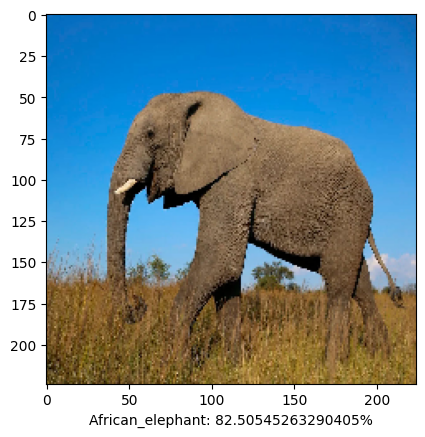

1/1 [==============================] - 1s 538ms/step


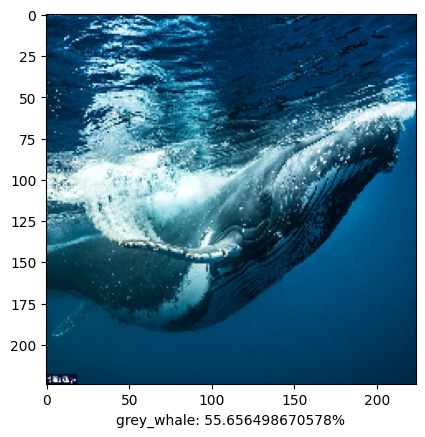

1/1 [==============================] - 1s 565ms/step


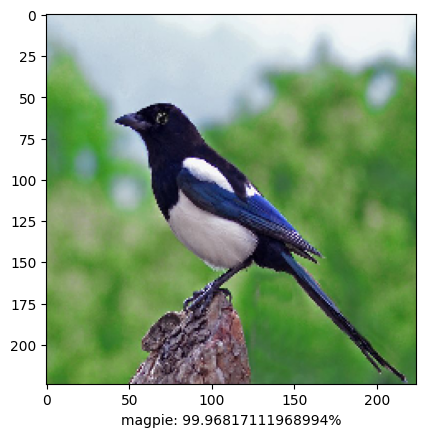

1/1 [==============================] - 1s 584ms/step


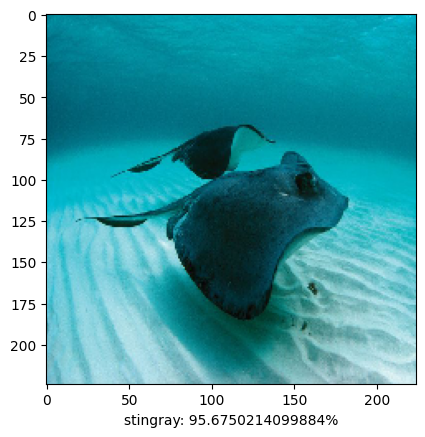

1/1 [==============================] - 1s 545ms/step


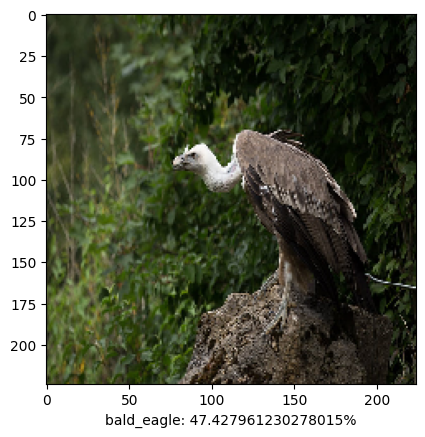

In [ ]:
images_names = ['elephant.jpg', 'kit.jpg', 'magpie.jpg', 'stingray.jpg', 'vulture.jpg']
path = 'drive/MyDrive/test/5/'

classifier(images_names, model)

Работа с собственным датасетом

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
data_dir = 'drive/MyDrive/dataset'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3300 files belonging to 3 classes.
Using 2640 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3300 files belonging to 3 classes.
Using 660 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['bird', 'cat', 'dog']


In [ ]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path

In [ ]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [ ]:
download_dir = Path('drive/MyDrive/dataset')

In [ ]:
traingen = train_generator.flow_from_directory(download_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               # classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(download_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               # classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

Found 2805 images belonging to 3 classes.
Found 495 images belonging to 3 classes.


In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
input_shape = (224, 224, 3)
# optim_1 = Adam(learning_rate=0.001)
n_classes=3

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 2

In [ ]:
optim_2 = Adam(lr=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback

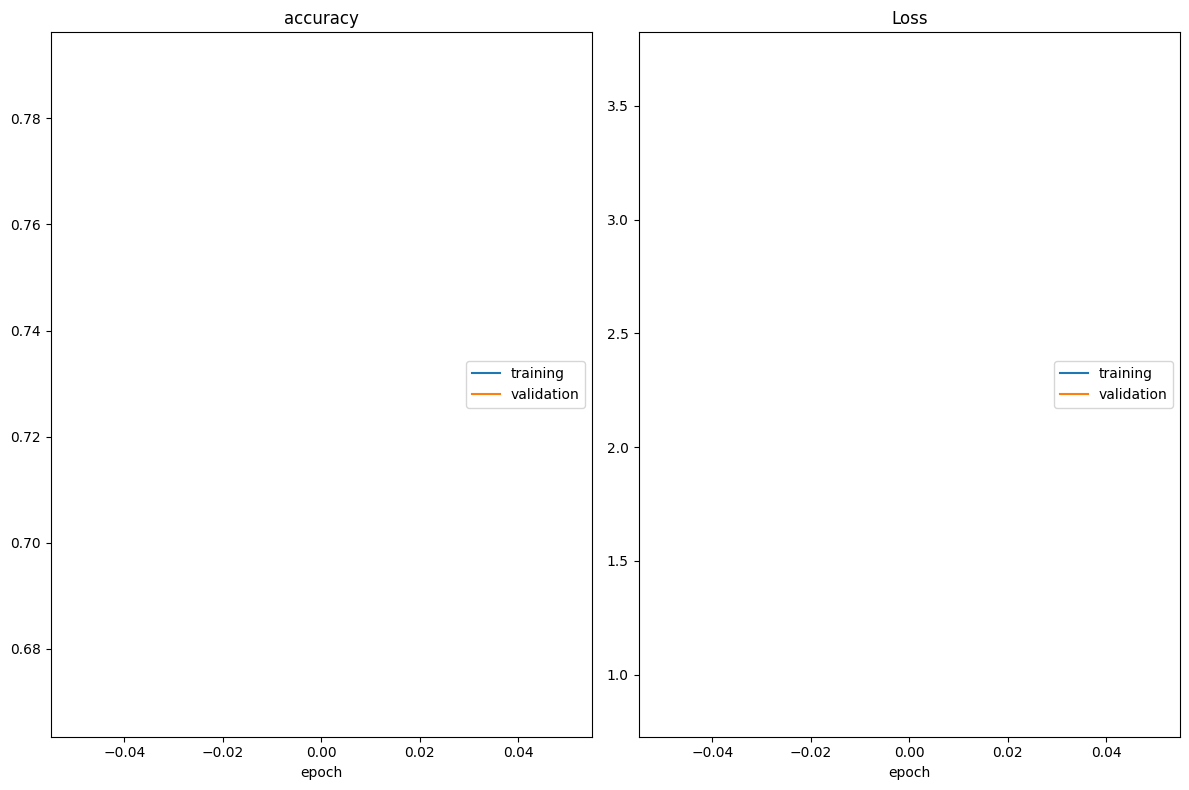

accuracy
	training         	 (min:    0.669, max:    0.669, cur:    0.669)
	validation       	 (min:    0.790, max:    0.790, cur:    0.790)
Loss
	training         	 (min:    3.683, max:    3.683, cur:    3.683)
	validation       	 (min:    0.868, max:    0.868, cur:    0.868)
43/43 [==============================] - 2094s 48s/step - loss: 3.6830 - accuracy: 0.6695 - val_loss: 0.8675 - val_accuracy: 0.7902
Epoch 2/2
43/43 [==============================] - ETA: 0s - loss: 0.5476 - accuracy: 0.8220 

In [ ]:
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')
plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [ ]:
img_path = 'drive/MyDrive/test/cat/cat_1.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = vgg_model_ft.predict(x)

1/1 [==============================] - 1s 1s/step


In [ ]:
class_names = ['bird', 'cat', 'dog']

max(features[0])

1.0

In [ ]:
def plot_image(predictions):
  img = predictions[0]
  plt.xlabel(f'{predictions[1]}: {predictions[2]*100}%')
  plt.imshow(img)
  plt.show()

In [ ]:
test_path = 'drive/MyDrive/test/all/all/'

def classifier(model):
  predictions = []
  for i in range(1, 16):
    img_path = test_path + f'{i}.jpg'
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)
    plot_image([img, class_names[np.argmax(features)], max(features[0])])

1/1 [==============================] - 1s 590ms/step


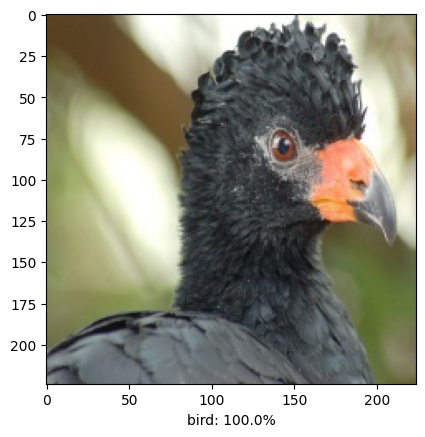

1/1 [==============================] - 1s 583ms/step


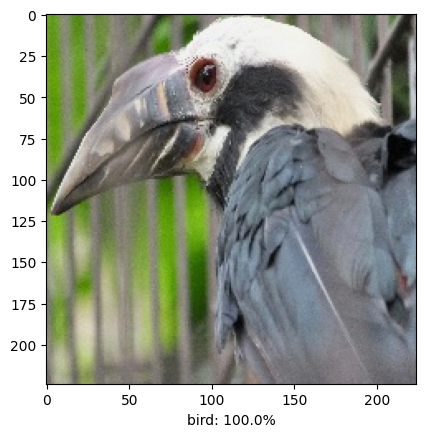

1/1 [==============================] - 1s 559ms/step


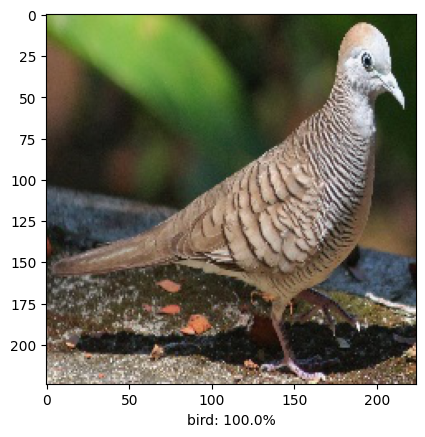

1/1 [==============================] - 1s 532ms/step


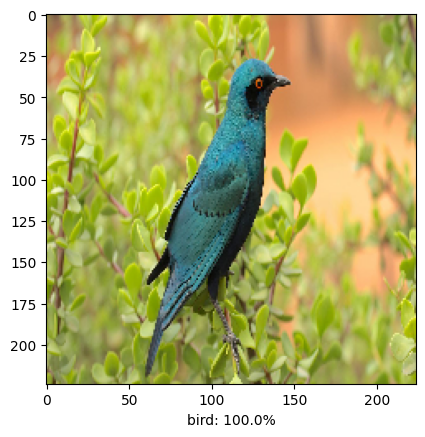

1/1 [==============================] - 1s 996ms/step


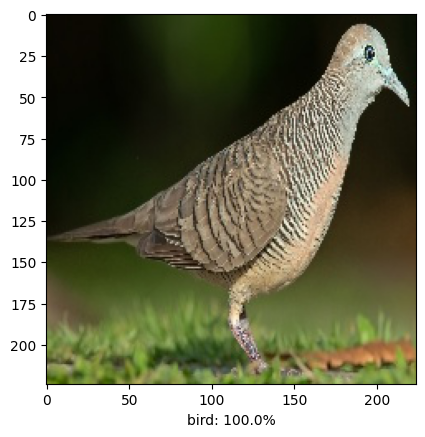

1/1 [==============================] - 1s 940ms/step


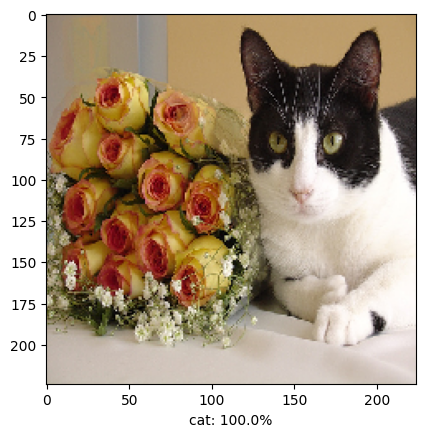

1/1 [==============================] - 1s 527ms/step


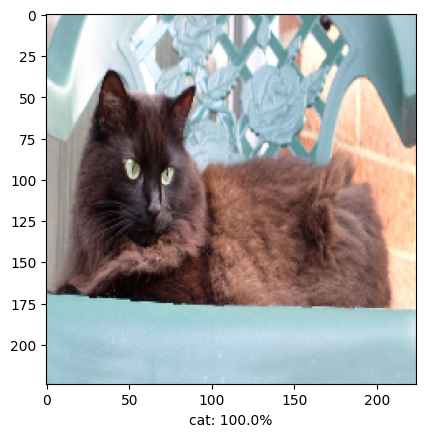

1/1 [==============================] - 1s 525ms/step


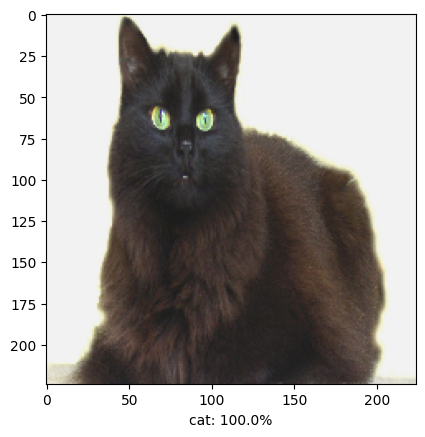

1/1 [==============================] - 1s 521ms/step


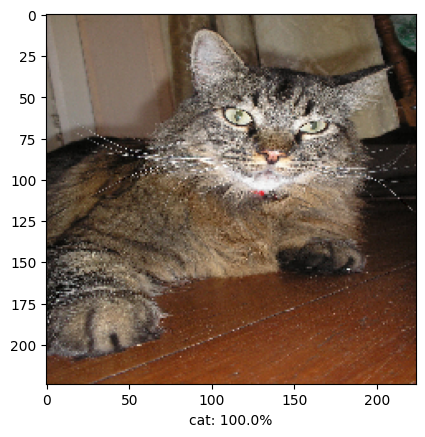

1/1 [==============================] - 1s 530ms/step


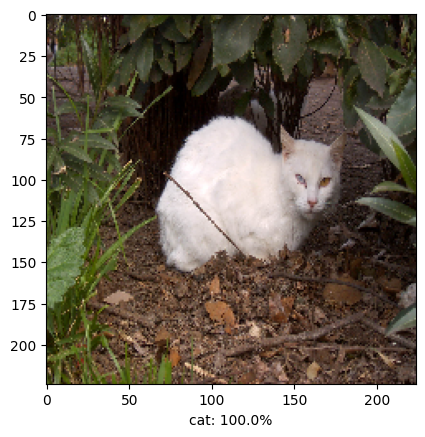

1/1 [==============================] - 1s 546ms/step


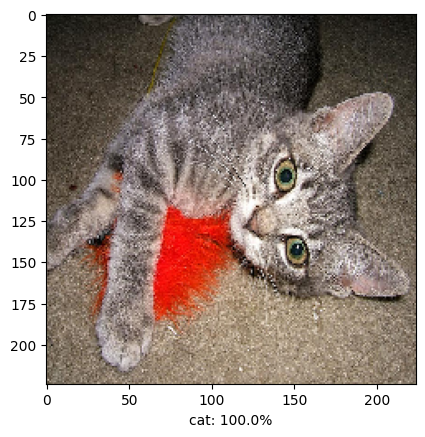

1/1 [==============================] - 1s 512ms/step


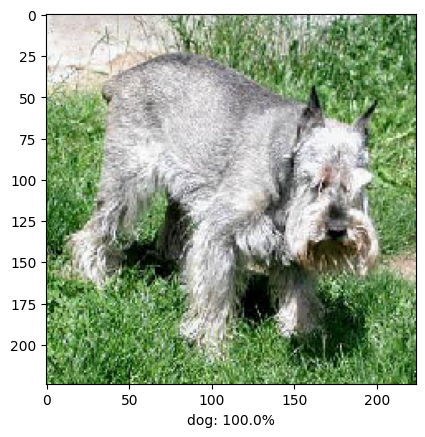

1/1 [==============================] - 1s 533ms/step


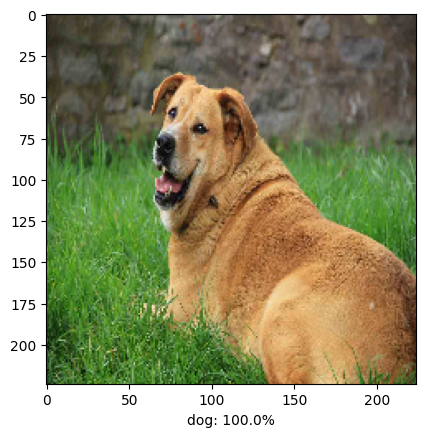

1/1 [==============================] - 1s 560ms/step


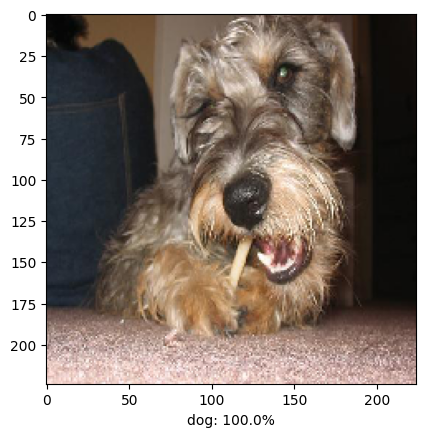

1/1 [==============================] - 1s 983ms/step


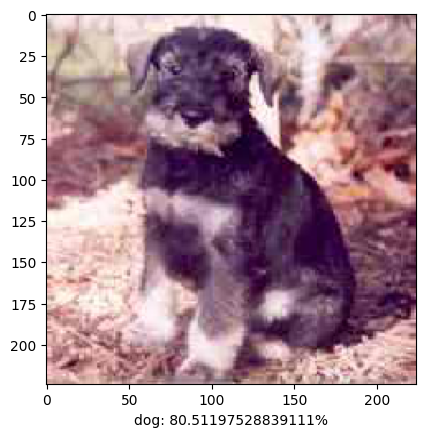

In [ ]:
classifier(vgg_model_ft)

In [ ]:
vgg_model_ft.save('drive/MyDrive/model/vgg_model_ft.h5')